###### Authors: Gabriele Bani (11640758), Bence Keresztury (11797967), Andrii Skliar (11636785)

## INFORMATION RETRIEVAL HOMEWORK 1

##### Link to google doc: https://docs.google.com/document/d/1JeqVB5HVqv3lq5GrltYqbq9dmbQpUf_NCNpow78WEBI/edit


### Theoretical Part (15 pts)

----

#### Hypothesis Testing – The problem of multiple comparisons [5 points]

Experimentation in AI often happens like this:
1. Modify/Build an algorithm
2. Compare the algorithm to a baseline by running a hypothesis test.
3. If not significant, go back to step 1.
4. If significant, start writing a paper.

#### How many hypothesis tests, m, does it take to get to (with Type I error for each test = α):

P($m^{th}$ experiment gives significant result | m experiments lacking power to reject $H_0$)?

For the $m^{th}$ experiment to be the first to give a significant result, all the previous ones have to be non significant. We have a significant result with probability $\alpha$ and $m-1$ non significant results with probability $(1-\alpha)^{m-1}$

P($m^{th}$ experiment gives significant result | m experiments lacking power to reject $H_0$) = $\alpha (1-\alpha)^{m-1}$


P(at least one significant result | m experiments lacking power to reject $H_0$)?

We have that the probability of getting one or more significant results is 1 - the probability of getting no significant result, because either one of the two events must always happen.
The probability of getting one single non significant result is $1-\alpha$, and assuming the independence of the experiments, the probability of getting m significant experiments is $(1-\alpha)^m$. So we can write

P(at least one significant result | m experiments lacking power to reject $H_0$) =
1 -  P(zero(no) significant result | m experiments lacking power to reject $H_0$) = $1 - (1 - \alpha)^m $


---

#### Bias and unfairness in Interleaving experiments (10 points)


Balance interleaving has been shown to be biased in a number of corner cases. An example was given during the lecture with two ranked lists of length 3 being interleaved, and a randomly clicking population of users that resulted in algorithm A winning $\frac{2}{3}$ of the time, even though in theory the percentage of wins should be 50% for both algorithms. 

__Can you come up with a situation of two ranked lists of length 3 and a distribution of clicks over them for which Team-draft interleaving is unfair to the better algorithm?__

The corner case can be set up in a following way:
- Let's say we have three links with number of clicks credited to each of them, namely:
    - a (50 clicks)
    - b (50 clicks)
    - c (4 clicks)
    - d (0 clicks)
    - e (0 clicks)
- We assume, that number of clicks can be used as a relevance measure for the ranking, so, algorithms, which picked the links with higher number of clicks are better.
- We have two ranked lists, namely:
    - Ranking A: [b, c, d]
    - Ranking B: [a, b, e]

This means, that ranking B is better than ranking A, because it has more clicks in total. However, when we apply team-draft interleaving to it, we will have following six combinations:
- [$b^A$, $a^B$, $d^B$] - tie
- [$b^A$, $a^B$, $c^A$, $e^A$] - ranker A wins
- [$b^A$, $a^B$, $c^A$, $d^B$] - ranker A wins
- [$a^B$, $b^A$, $d^B$] - tie
- [$a^B$, $b^A$, $c^A$, $d^B$] - ranker A wins
- [$a^B$, $b^A$, $c^A$, $e^B$] - ranker A wins

So, as we can see, ranker A always either wins or goes into a tie even though it's worse.

This is due to the fact that when using team-draft interleaving, clicks can only be credited to one algorithm, thus, if link belongs to two of them, it might be removed from the other ranking and that might lead to possible corner cases (as the one mentioned above).

---

#### Experimental Part [85 pts]

---

Commercial search engines use both offline and online approach in evaluating a new search algorithm: they first use an offline test collection to compare the production algorithm (*P*) with the new experimental algorithm (*E*); if *E* statistically significantly outperforms *P* with respect to the evaluation measure of their interest, the two algorithms are then compared online through an interleaving experiment.


For the purpose of this homework we will assume that the evaluation measures of interest are:
1. Binary evaluation measures
    * Precision at rank k,
    * Recall at rank k,
    * Average Precision,
2. Multi-graded evaluation measures
    * Normalized Discounted Cumulative Gain at rank k (nDCG@k),
    * Expected Reciprocal Rank (ERR).

Further, for the purpose of this homework we will assume that the interleaving algorithms of interest are:
1. Team-Draft Interleaving (Joachims. "Evaluating retrieval performance using clickthrough data". Text Mining 2003.),
2. Probabilistic Interleaving (Hofmann, Whiteson, and de Rijke. "A probabilistic method for inferring preferences from clicks." CIKM 2011.).
 
In an interleaving experiment the ranked results of *P* and *E* (against a user query) are interleaved in a single ranked list which is presented to a user. The user then clicks on the results and the algorithm that receives most of the clicks wins the comparison. The experiment is repeated for a number of times (impressions) and the total wins for *P* and *E* are computed. 


A Sign/Binomial Test is then run to examine whether the difference in wins between the two algorithms is statistically significant (or due to chance). Alternatively one can calculate the proportion of times the *E* wins and test whether this proportion, *p*, is greater than $p_0=0.5$. This is called an 1-sample 1-sided proportion test.


One of the key questions however is **whether offline evaluation and online evaluation outcomes agree with each other**. In this homework you will determine the degree of agreement between offline evaluation measures and interleaving outcomes, by the means of simulations. A similar analysis using actual online data can be found at Chapelle et al. “Large-Scale Validation and Analysis of Interleaved Search Evaluation”.

---

##### [Based on Lecture 1]

###### Step 1: Simulate Rankings of Relevance for E and P [5 points]

In the first step you will generate pairs of rankings of relevance, for the production *P* and experimental *E*, respectively, for a hypothetical query **q**. Assume a 3-graded relevance, i.e. {N, R, HR}. Construct all possible *P* and *E* ranking pairs of length 5. This step should give you about.


Example:
* P: {N N N N N}; E: {N N N N R}
* …
* P: {HR HR HR HR R}; E: {HR HR HR HR HR}


(Note 1: If you do not have enough computational power, sample 5000 pair uniformly at random to show your work.)

In [1]:
from itertools import product
import math
import random
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

log2 = lambda x: math.log(x, 2)

# list of all possible relevance values
relevance = ['N', 'R', 'HR']
# creating all possible pairs of rankings of length 5
single_ranking = product(relevance, repeat=5)
# creating all possible pairs of rankings
# splitting pairs of rankings into two different lists.
# doing this so that rankings of two algorithm (p, e) being compared stay separated
p_ranking, e_ranking = zip(*product(single_ranking, repeat=2))

###### Step 2: Implement Evaluation Measures [10 points]

Implement 1 binary and 2 multi-graded evaluation measures out of the 7 measures mentioned above. 
(Note 2: Some of the aforementioned measures require the total number of relevant and highly relevant documents in the entire collection – pay extra attention on how to find this)


In [2]:
# converting relevance lables into values (useful for such algorithms as nDCG_k & ERR)
def rel2int(rel):
    return 1 if rel == 'R' else 2 if rel == 'HR' else 0

In [3]:
# calculating k-precision offline measure
def k_precision(rankings, k):
    # k-precision doesn't include the relevance grade, so, we assume that
    # documents with 'R' and 'HR' relevance are relevant, while those with 'N' are not
    precisions = [1 / k * sum((1 if r in ['R', 'HR'] else 0
                               for r in ranking[:k])) for ranking in rankings]
    return precisions

In [4]:
# calculating normalized DCG@k offline measure
def nDCG_k(rankings, k):
    normalize_const = rel2int(relevance[-1]) ** k
    # adding 1 to r since in the original formula it goes from 1 to n
    dcgk = [sum(((2 ** rel2int(p_i) - 1) / log2(2 + r)
                 for r, p_i in enumerate(ranking[:k]))) / normalize_const
            for ranking in rankings]
    return dcgk

In [5]:
# calculating ERR offline measure
def ERR(rankings, k):
    ERR_res = list()
    for ranking in rankings:
        p = 1
        ERR = 0
        max_val = rel2int(relevance[-1])
        for i, r_i in enumerate(ranking[:k]):
            R_i = (2 ** rel2int(r_i) - 1) / (2 ** max_val)
            # adding 1 to i since in the original formula it goes from 1 to n
            ERR = ERR + p * R_i / (i + 1)
            p = p * (1 - R_i)
        ERR_res.append(ERR)

    return ERR_res

###### Step 3: Calculate the $\Delta measure$ [0 points]

For the three measures and all *P* and *E* ranking pairs constructed above calculate the difference: $\Delta measure = measure_E-measure_P$. Consider only those pairs for which *E* outperforms *P*.


In [6]:
# calculating the differences based of arbitrary measure, returns a list of indices and values where the difference is positive (so, algorithm e outperforms p)
def delta_measure(p_evals, e_evals):
    # with the zip, we actually pair the elements of the p and e lists
    idx, delta = zip(*[(idx, e_eval - p_eval) for idx, (p_eval, e_eval) in enumerate(zip(p_evals, e_evals)) if e_eval > p_eval])
    # converting to lists, because zip returns zip objects by default
    return list(idx), list(delta)

# comparing two provided algorithms (p & e in our case)
def algo_comp(eval_method, p_ranking, e_ranking, k):
    p_evals, e_evals = eval_method(p_ranking, k), eval_method(e_ranking, k)
    return delta_measure(p_evals, e_evals)

In [7]:
k = 5

idx, delta = algo_comp(k_precision, p_ranking, e_ranking, k)
print('Number of cases where E outperforms P for k-precision (k=5) evaluation algorithm: {}, percentage: {}'.format(len(delta), len(delta)/len(p_ranking)))

idx, delta = algo_comp(nDCG_k, p_ranking, e_ranking, k)
print('Number of cases where E outperforms P for nDCG@k (k=5) evaluation algorithm: {}, percentage: {}'.format(len(delta), len(delta)/len(p_ranking)))

idx, delta = algo_comp(ERR, p_ranking, e_ranking, k)
print('Number of cases where E outperforms P for ERR (k=5) evaluation algorithm: {}, percentage: {}'.format(len(delta), len(delta)/len(p_ranking)))

Number of cases where E outperforms P for k-precision (k=5) evaluation algorithm: 21762, percentage: 0.3685413808870599


Number of cases where E outperforms P for nDCG@k (k=5) evaluation algorithm: 29376, percentage: 0.4974851394604481


Number of cases where E outperforms P for ERR (k=5) evaluation algorithm: 29369, percentage: 0.4973665938457891


----

#### [Based on Lecture 2]


###### Step 4: Implement Interleaving [15 points]

Implement Team-Draft Interleaving OR Balanced Interleaving.

The interleaving algorithms should:
- given two rankings of relevance interleave them into a single ranking
- given the users clicks on the interleaved ranking assign credit to the algorithms that produced the rankings.

Note 4: Note here that as opposed to a normal interleaving experiment where rankings consists of urls or docids, in our case the rankings consist of relevance labels. Hence in this case:
- you will assume that E and P return different documents
- the interleaved ranking will also be a ranking of labels.

In [8]:
# Team Draft Interleaving
def t_d_interleaving(A, B):
    # we use sets for easier computation of the condition in the while loop
    # since all documents have different ids, using indices as ids
    # also, for this task we can assume, that both given rankings are of length 5
    # so, using indices 0-4 for documents from A and 5-9 for B
    setA, setB = set((i for i in range(len(A)))),\
                 set((i + len(A) for i in range(len(B))))
    teamA, teamB = set(), set()
    I, setI = [], set()
    # used to keep track whether elements in the interleaved ranking belong to ranking A or ranking B
    # belongs is a boolean array with True if item belongs to ranking A and False otherwise
    belongs, belongsToA = [], False
    # while there are elements of A or B still not in interleaved set
    # so, until one of the rakings has all of its elements in the interleaved ranking
    while((setA | setI != setI) and (setB | setI != setI)):
        # instead of copy-pasting, set variables to those of the desired ranking (A or B)
        if len(teamA) < len(teamB) or (len(teamA) == len(teamB)
                                       and random.choice([True, False])):
            winner, setwin, team, belongsToA = A, setA, teamA, True
        else:
            winner, setwin, team, belongsToA = B, setB, teamB, False
        # get first element of the generator
        idx = next((x for x in setwin if x not in setI)) # there must be one element, since we got into the loop
        # since document ids are indices, check if it is coming from A or B (by index) and add it interleaved ranking
        el = winner[idx] if idx < len(setA)-1 else winner[idx - len(setA)]
        # add document to interleaved ranking
        I.append(el)
        # add boolean value to boolean list of belongings
        belongs.append(belongsToA)
        # add document to winning team
        team.add(idx)
        # add document to interleaved ranking set (set of indices - ids of documents)
        setI.add(idx)
    # here we assume, that interleaved ranking should be of the same length as rankings themselves (as suggested on Piazza)
    return I[:5], belongs[:5]

# calculating the points based on the interleaving and click indexes
def interleaving_points(interleaving, belongs, click_idx):
    # checking the boolean value of interleaved ranking to see if value comes from A or B
    pointsA = sum((1 for idx in click_idx if belongs[idx]))
    pointsB = sum((1 for idx in click_idx if not belongs[idx]))
    return pointsA, pointsB

---

#### [Based on Lecture 3]


##### Step 5: Implement User Clicks Simulation (15 points)
Having interleaved all the ranking pairs an online experiment could be ran. However, given that we do not have any users (and the entire homework is a big simulation) we will simulate user clicks.

We have considered a number of click models including:
- Random Click Model (RCM)
- Position-Based Model (PBM)
- Simple Dependent Click Model (SDCM)
- Simple Dynamic Bayesian Network (SDBN)

Consider two different click models:
- the Random Click Model (RCM)
- one out of the remaining 3 aforementioned models

The parameters of some of these models can be estimated using the Maximum Likelihood Estimation (MLE) method, while others require using the Expectation-Maximization (EM) method.

Implement the two models so that:
- there is a method that learns the parameters of the model given a set of training data
- there is a method that predicts the click probability given a ranked list of relevance labels
- there is a method that decides - stochastically - whether a document is clicked based on these probabilities.

Having implemented the two click models, estimate the model parameters using the Yandex Click Log [ [link] ](https://drive.google.com/open?id=1tqMptjHvAisN1CJ35oCEZ9_lb0cEJwV0).

Note 6: Do not learn the attractiveness parameter $\alpha_{uq}$

____Yandex Click Log File____:

The dataset includes user sessions extracted from Yandex logs, with queries, URL rankings and clicks. To allay privacy concerns the user data is fully anonymized. So, only meaningless numeric IDs of queries, sessions, and URLs are released. The queries are grouped only by sessions and no user IDs are provided. The dataset consists of several parts. Logs represent a set of rows, where each row represents one of the possible user actions: query or click.

In the case of a Query:

SessionID TimePassed TypeOfAction QueryID RegionID ListOfURLs


In the case of a Click:

SessionID TimePassed TypeOfAction URLID


- SessionID - the unique identifier of the user session.
- TimePassed - the time elapsed since the beginning of the current session in standard time units.
- TypeOfAction - type of user action. This may be either a query (Q), or a click (C).
- QueryID - the unique identifier of the request.
- RegionID - the unique identifier of the country from which a given query. This identifier may take four values.
- URLID - the unique identifier of the document.
- ListOfURLs - the list of documents from left to right as they have been shown to users on the page extradition Yandex (top to bottom).

In [9]:
# in the book (Click Models for Web Search), three options for choosing alpha depending on relevance value are given (in the table 8.1, p. 70)
# implementing each of these: perfect, navigational, informational
def rel2prob_perfect(rel):
    return 0.5 if rel == 'R' else 1.0 if rel == 'HR' else 0
def rel2prob_navigation(rel):
    return 0.5 if rel == 'R' else 0.95 if rel == 'HR' else 0.05
def rel2prob_information(rel):
    return 0.7 if rel == 'R' else 0.9 if rel == 'HR' else 0.4

In [10]:
from abc import ABCMeta, abstractclassmethod

# Abstact Class for Click Models
class ClickModel:
    # no method template for predicting click probability due to the chosen models (RCM & SDCM)
    # RCM will have the same probability for every document
    # SDCM depends on whether previous document has been clicked, so only reasonable to model it directly when generating clicks
    __metaclass__ = ABCMeta

    # during the initialization, model is getting trained (so, finds parameters of the model)
    def __init__(self, train_file):
        self.train_file = train_file
        # as far as only one paramter is used in both models, no point in setting parameters as a dictionary (similar to how it's done in scikitlearn) or in any other way
        self.param = self.model_params()

    # template method for learning the parameters of the model given a set of training data
    @abstractclassmethod
    def model_params(self):
        pass

    # given click probability, decides - stochastically - whether a document is clicked based on these probabilities
    def is_clicked(self, click_prob):
        if (random.uniform(0,1) <= click_prob):
            return True
        return False

    # generates which documents will be clicked, given a ranked list of relevance labels
    @abstractclassmethod
    def generate_clicks(self, ranking):
        pass

In [11]:
# Class for Random Click Model
class RCM(ClickModel):
    def __init__(self, train_file):
        super().__init__(train_file)

    def __name__(self):
        return "Random Click Model"

    # learn probability of a click as a number of clicks divided by total number of documents shown
    def model_params(self):
        clicks = 0
        docs_shown = 0
        with open(self.train_file, 'r') as train_data:
            for line in train_data:
                splitted_line = line.strip().split('\t')
                if splitted_line[2] == 'Q':
                    docs_shown += len(splitted_line)-5
                    urls = [int(x) for x in splitted_line[5:]]
                else:
                    urlID = int(splitted_line[3])
                    if urlID in urls:
                        clicks += 1
        return clicks/docs_shown

    # go over each document in a list, stochastically decide if it is clicked or not
    def generate_clicks(self, ranking):
        click_prob = self.param
        #interleaved ranking should be a list of documents
        click_idx = [i for i in range(len(ranking)) if self.is_clicked(click_prob)]
        return click_idx

In [12]:
# Class for Simple Dependent Click Model
class SDCM(ClickModel):

    # passing rel2prob (alpha) as an additional argument for the purpose of easier testing
    def __init__(self, train_file, rel2prob):
        super().__init__(train_file)
        self.rel2prob = rel2prob

    def __name__(self):
        return "Simple Dependent Click Model"

    def model_params(self):
        N = [0]*10 #denominator for every rank
        gamma = [0]*10 #numerator for every rang
        clicks = []
        remain = 0
        with open(self.train_file, 'r') as train_data:
            for line in train_data:
                splitted_line = line.strip().split('\t')
                cur_sessionID, action = int(splitted_line[0]), splitted_line[2]
                if action == 'Q':
                    if clicks != []:
                        #there are clicks on documents that are not retrieved by the current query sometimes in the dataset
                        #the for loop for finding l is done to ensure that we find the last document clicked that is also actually retrieved
                        for x in list(reversed(clicks)):
                            if x in urls:
                                l = urls.index(x)
                                break
                        for c in clicks:
                            if c in urls: #also here, check for clicks that actually are referred to retrieved documents
                                idx = urls.index(c)
                                N[idx] += 1 #add 1 to denominator
                                if idx != l: #adding to every gamma with rank != l because we are computing continuation probabilities
                                    gamma[idx] += 1
                        clicks = []
                    cur_queryID = int(splitted_line[3])
                    urls = [int(x) for x in splitted_line[5:]]
                else:
                    cur_click = int(splitted_line[3])
                    clicks.append(cur_click)
        return [l / p for l, p in zip(gamma, N)]

    def generate_clicks(self, ranking):
        alphas = [self.rel2prob(i) for i in ranking] #assign attractiveness scores based on the relevance of the document
        c_list = []
        gammas = self.param
        for i in range(len(ranking)):
            c = 1 if self.is_clicked(alphas[i]) else 0
            # the probability of clicking is given by attractiveness and examination, which is always one until we stop
            if c == 1:
                c_list.append(i)
                continuing = self.is_clicked(gammas[i])
                # given the probability of continuing at rank i, we decide whether to continue generating clicks
                if not continuing:
                    return c_list
        # returning a list of click indexes
        return c_list

##### Step 6: Simulate Interleaving Experiment [10 points]

Having implemented the click models, it is time to run the simulated experiment.

For each of interleaved ranking run N simulations for each one of the click models implemented and measure the proportion *p* of wins for *E*.

Note 7: Some of the models above include an attractiveness parameter $\alpha_{uq}$. Use the relevance label to assign this parameter by setting $\alpha_{uq}$ for a document u in the ranked list accordingly. (See [Click Models for Web Search](clickmodels.weebly.com/uploads/5/2/2/5/52257029/mc2015-clickmodels.pdf))


In [13]:
# simulate an interleaving experiment
def interleave_sim(click_model, p_ranking, e_ranking, N, include_ties):
    proportion_list = list()
    proportion_list_justwin = list()
    # run for every pair of rankings
    for i in range(len(p_ranking)):
        e_win_count = 0
        p_win_count = 0
        # get the interleaving and the belong list so we keep track of which of the two rankings the documents come from
        I, belongs = t_d_interleaving(p_ranking[i], e_ranking[i])
        # run for N times with the same interleaved ranking
        for j in range(N):
            #get the ranks of the clicked documents
            clicked_idxs = click_model.generate_clicks(I)
            pointsP, pointsE = interleaving_points(I, belongs, clicked_idxs)
            if pointsE > pointsP:
                e_win_count += 1
            elif pointsP > pointsE:
                p_win_count += 1
            else:
                # depending on whether ties are included or not, assign 1/2 to both E and P or discard all ties
                if include_ties:
                    e_win_count += 1/2
                    p_win_count += 1/2
        if include_ties:
            # include ties, thus dividing by total number of runs for a given interleaved ranking
            proportion_list.append(e_win_count/N)
        else:
            # discard ties, thus dividing only by sum of wins (total number of runs excluding those which resulted in ties)
            proportion_list.append(e_win_count/(e_win_count + p_win_count))

    return proportion_list

def full_sim(eval_method, click_model, p_ranking, e_ranking, k, N, include_ties):
    # get indices and deltas for the cases, where E outperforms P
    idx, delta = algo_comp(eval_method, p_ranking, e_ranking, k)
    # choose p_rankings and e_rankings, where E outperforms P to perform online evaluation only on those (funnel approach)
    p_updated, e_updated = zip(*[(p_ranking[i], e_ranking[i]) for i in idx])
    # get the winning probabilities p
    proportions = interleave_sim(click_model, p_updated, e_updated, N, include_ties)
    return delta, proportions

##### Step 7: Results and Analysis [30 points]

Compare the results of the offline experiments (i.e. the values of the 𝛥measure) with the results of the online experiment (i.e. proportion of wins), analyze them and reach your conclusions regarding their agreement.

- Use easy to read and comprehend visuals to demonstrate the results;
- Analyze the results on the basis of
    - the evaluation measure used,
    - the interleaving method used,
    - the click model used.

- Report and ground your conclusions.

Note 8: This is the place where you need to demonstrate your deeper understanding of what you have implemented so far; hence the large number of points assigned. Make sure you clearly do that so that the examiner of your work can grade it accordingly.

In [14]:
from scipy.stats import binom_test
import matplotlib.pyplot as plt

# Binomial test
# input: proportion of wins for E
# output: p-value of the test
def binom_comp(proportions):
    # get the sign of prop - 0.5
    sign = [1 if prop > 0.5 else -1 for prop in proportions if prop != 0.5]
    # count how many times E and P wins
    succ, fail = sign.count(1), sign.count(-1)
    print('Number of successes {}, number of failures {}'.format(succ, fail))
    return binom_test((succ, fail))

In [15]:
k = 5
N = 30
model = SDCM('YandexRelPredChallenge.txt', rel2prob_information)
# model = RCM('YandexRelPredChallenge.txt')

delta, props = full_sim(ERR, model, p_ranking, e_ranking, k, N, include_ties=True)
print('Sign test result for ERR including ties: {}'.format(binom_comp(props)))
delta, props = full_sim(ERR, model, p_ranking, e_ranking, k, N, include_ties=False)
print('Sign test result for ERR excluding ties: {}'.format(binom_comp(props)))
delta, props = full_sim(nDCG_k, model, p_ranking, e_ranking, k, N, include_ties=False)
print('Sign test result for nDCG@k excluding ties: {}'.format(binom_comp(props)))

Number of successes 17152, number of failures 11491
Sign test result for ERR including ties: 8.023638682545249e-247


Number of successes 17025, number of failures 11582
Sign test result for ERR excluding ties: 1.6469382241037842e-228


Number of successes 17434, number of failures 11293
Sign test result for nDCG@k excluding ties: 1.4492274435579903e-289


##### Purpose
The main purpose of our experiments was to evaluate whether the offline evaluation algorithms and online evaluation measures agree on their results. To test this, we simulated the often used funnel approach, i.e. we evaluated the online measures only in cases where the experimental algorithm E outperformed the existing production algorithm P in the offline measure.

In this simple experiment setting, we use three different offline measures: k-precision, ERR and nDCG@k. For both ERR and nDCG@k, we assign 2 points for highly relevant documents (HR), 1 for relevant documents (R) and 0 for non relevant documents (N)
To use online measures, we interleave the rankings produced in the first part of the exercise, which are of length 5, and then keep the first 5 elements of the interleaved ranking and assign points to the ranking algorithms $P$ and $E$ based on the interleaved ranking.

Regarding the click models, we use the following:

###### RCM

The random click model is very simple, and the only parameter that can be learned from the dataset is the probability $p$ of clicking on any document. From the dataset, we get a value of $0.13$ (rounded to two decimals)

###### SDCM

For this model, we estimate the probabilities $\gamma_r$.
From the dataset, the estimated parameters are $\boldsymbol \gamma = (0.31, 0.53, 0.56, 0.58, 0.57, 0.55, 0.55, 0.50, 0.46, 0.23)$

As requested by the task, we iterate for every pair of rankings generated by $P$ and $E$ in the previous sections, and for every calculate both the delta measure and the percentage of wins $p$ for the algorithm E over 50 runs. For every pair of delta and p value, for every run we generate clicks for its interleaved ranking based on a certain click model (RCM or SDCM). We also use different sets of actractiveness parameters, as specified in table 8.1.
For every of the models, here there is the attractiveness for, respectively, highly relevant (HR), relevant (R) and not relevant (N) documents.

- perfect model: 1.0, 0.5, 0

- navigational model: 0.95, 0.5, 0.05

- informational model: 0.9, 0.7, 0.5

The reason to do the experiments with different actractiveness parameters is that we expected them to influence very much the clicks generated, and since we want to try to correctly find whether offline and online measures correlate, we do not want to bias our results to just one particular setting of attractiveness parameters.

To test whether the online evaluation agrees with the results of the offline algorithms (delta measures coming from ERR and nDCG@k), we performed a sign test, as follows:
1. After interleaving results provided by the the algorithms E and P, we generated clicks based on the Simple Dependent Click Model.
2. We performed 30 impressions on every interleaved ranking and counted how many times results from the experimental algorithm were clicked more often and thus how often the production algorithm won. 
3. We assigned +1 to those runs where E won more times than P, and -1 otherwise. Moreover we included two options regarding ties: we either omitted counting ties at all (include_ties=False) or we included it (include_ties=True) and gave 0.5 points to both algorithms. After calculating number of wins, we divided it by either number of impressions or number of wins (so, impressions excluding ties) for ties included and excluded respectively to get win proportionality for algorithm E.
4. We performed sign test on the win proportionalities, that we got.

Since we know that the sum of these runs follow binomial distribution, a sign test could indeed be performed, with the null hypothesis that the algorithm E has exactly the same chance winning as algorithm P. We found that the difference between the two is highly significant in all cases (offline measure is ERR or nDCG_k, include ties or not), so we can reject the null hypothesis. E wins significantly more often and the difference cannot be attributed to chance. This means that the tested offline and online evaluation measures agree on their results, thus we confirm our main hypothesis.

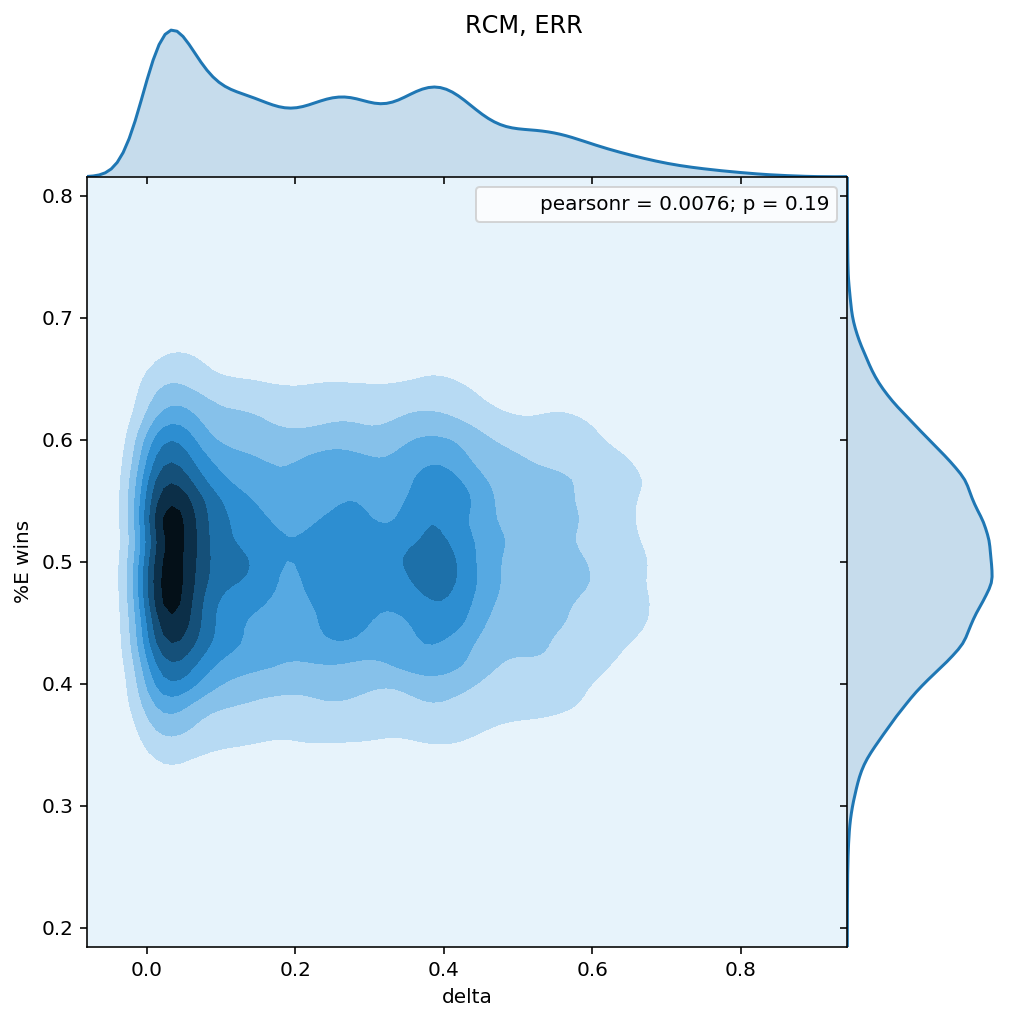

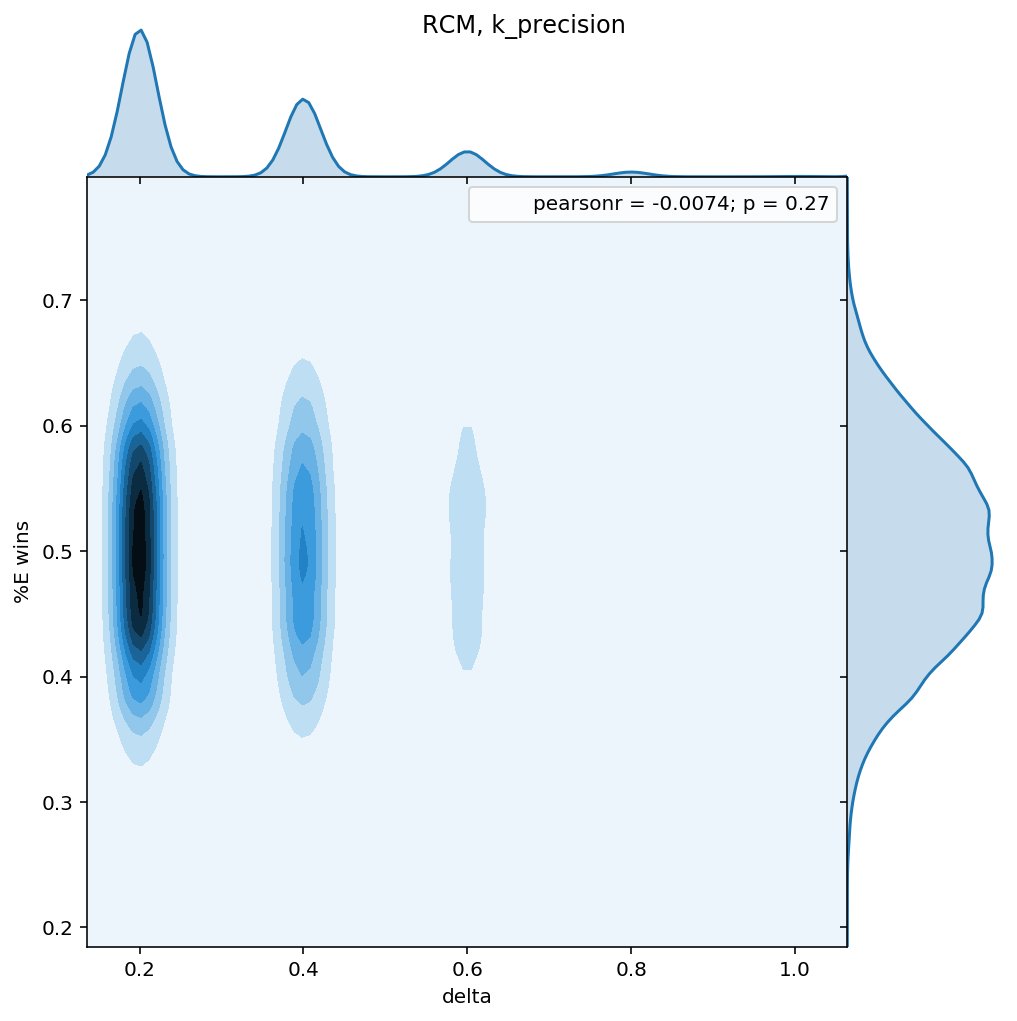

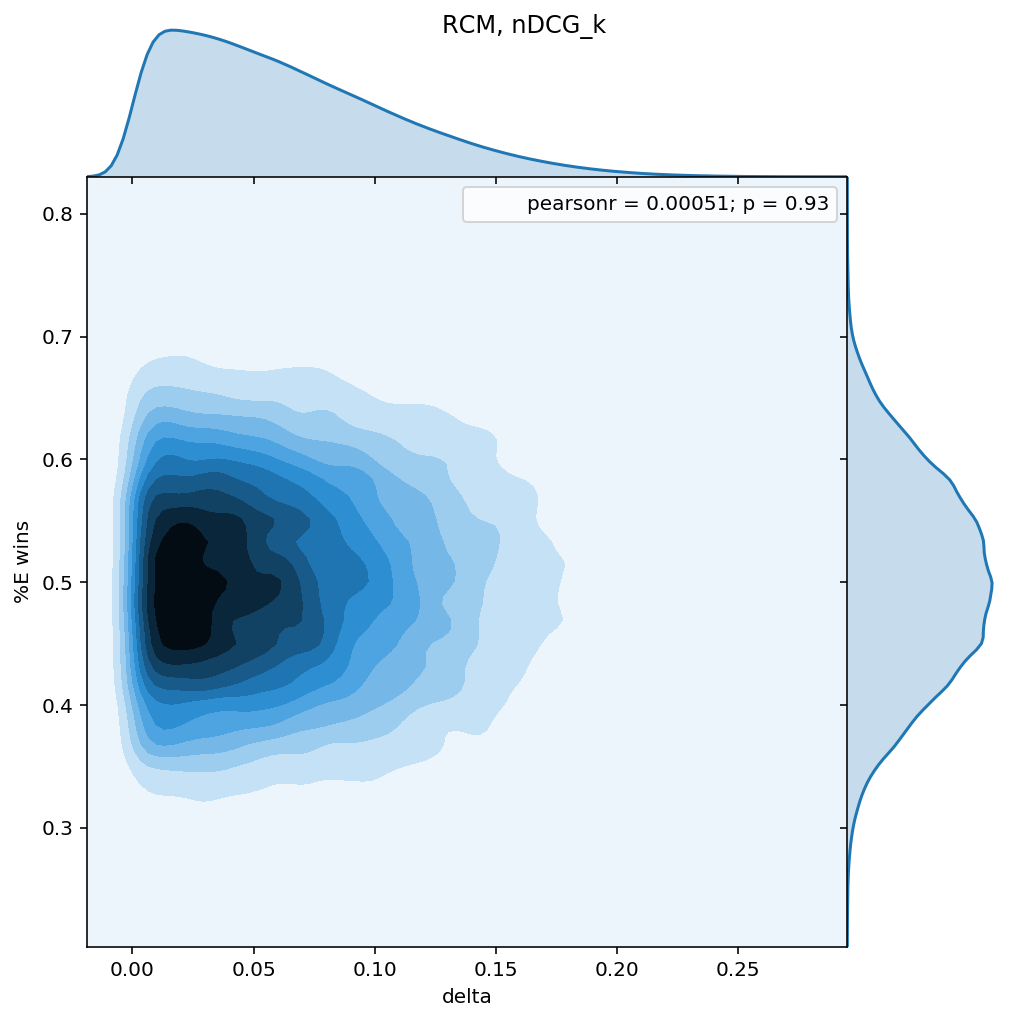

In [16]:
def RCM_plot(k, N):
    model = RCM('YandexRelPredChallenge.txt')
    for i, eval_model in enumerate([ERR, k_precision, nDCG_k]):
        delta, props = full_sim(eval_model, model, p_ranking, e_ranking, k, N, True)
        ax = sns.jointplot(np.array(delta), np.array(props), kind="kde", size=7, space=0).set_axis_labels("delta", "%E wins")
        ax.fig.suptitle('RCM, {0}'.format(eval_model.__name__))
        plt.show()

RCM_plot(5, 30)


The above graphs show the joint plot for delta (x axis) and p values (y axis), where darker color indicates that more points are in the area of that color.
Notice that on top of every plot we can find the distribution of the values of the offline measure (or more precisely, a continuous approximation of it). On the right, we can instead find the (approximate) distribution of the percentages of wins p for the algorithm E.


The first thing we can notice regarding the Random Click Model is the distribution of its values, which is centered at $0.5$ and symmetrical. We can see a continuous approximation of this distribution in the right side of the plots that use RCM. We find that there is no significant correlation between the scores it produces and the offline measures. This is due to the fact that the random click model does not take into account the rank of a document for calculating clicking probabilities, while all the offline measures are related to the rank of the documents. Also, the random click model does not take into account the attractiveness of the documents, so it generate clicks without distinguishing between relevant and non relevant documents. This is the opposite behavior of the offline methods, which take the relevance to account to calculate scores. Therefore, we conclude that our observations support the intuitive thought that the random click model, given its naive behavior, does not produce clicks that are representative of user behavior.

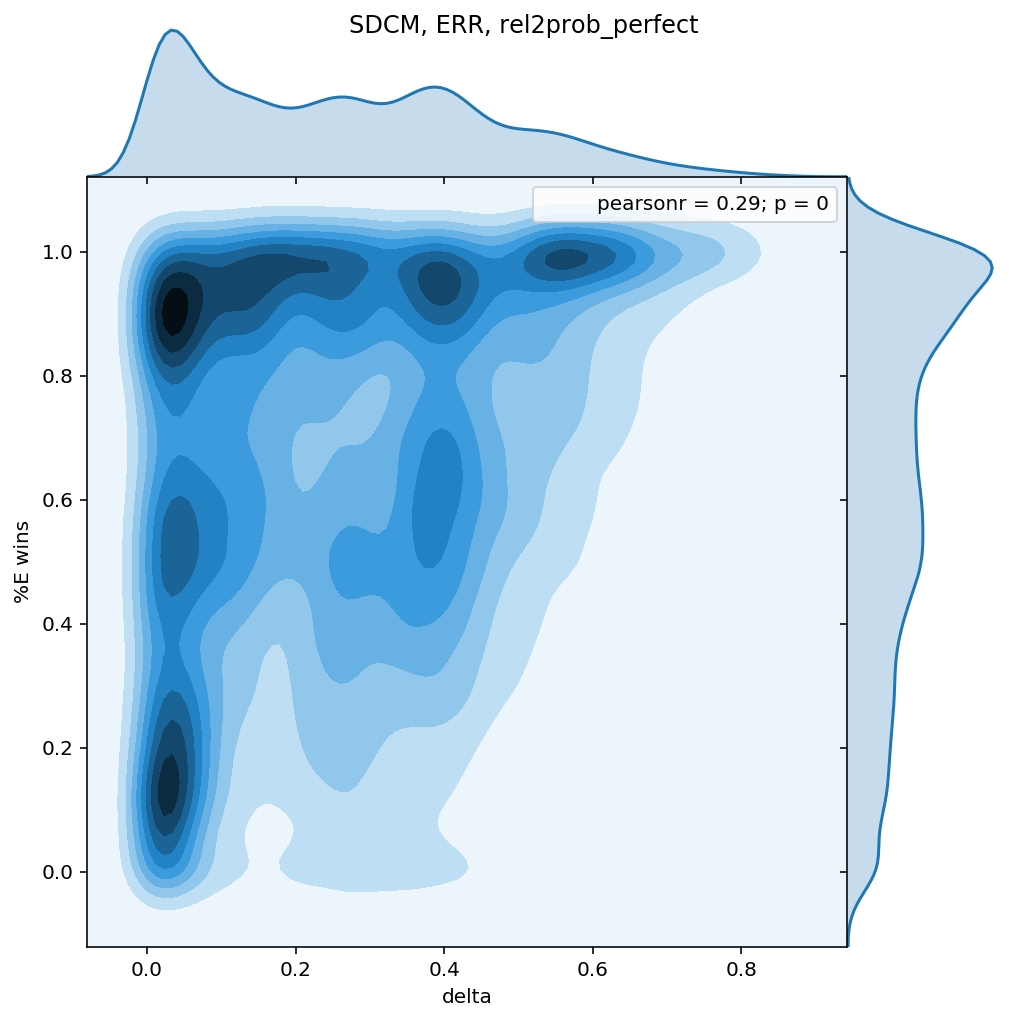

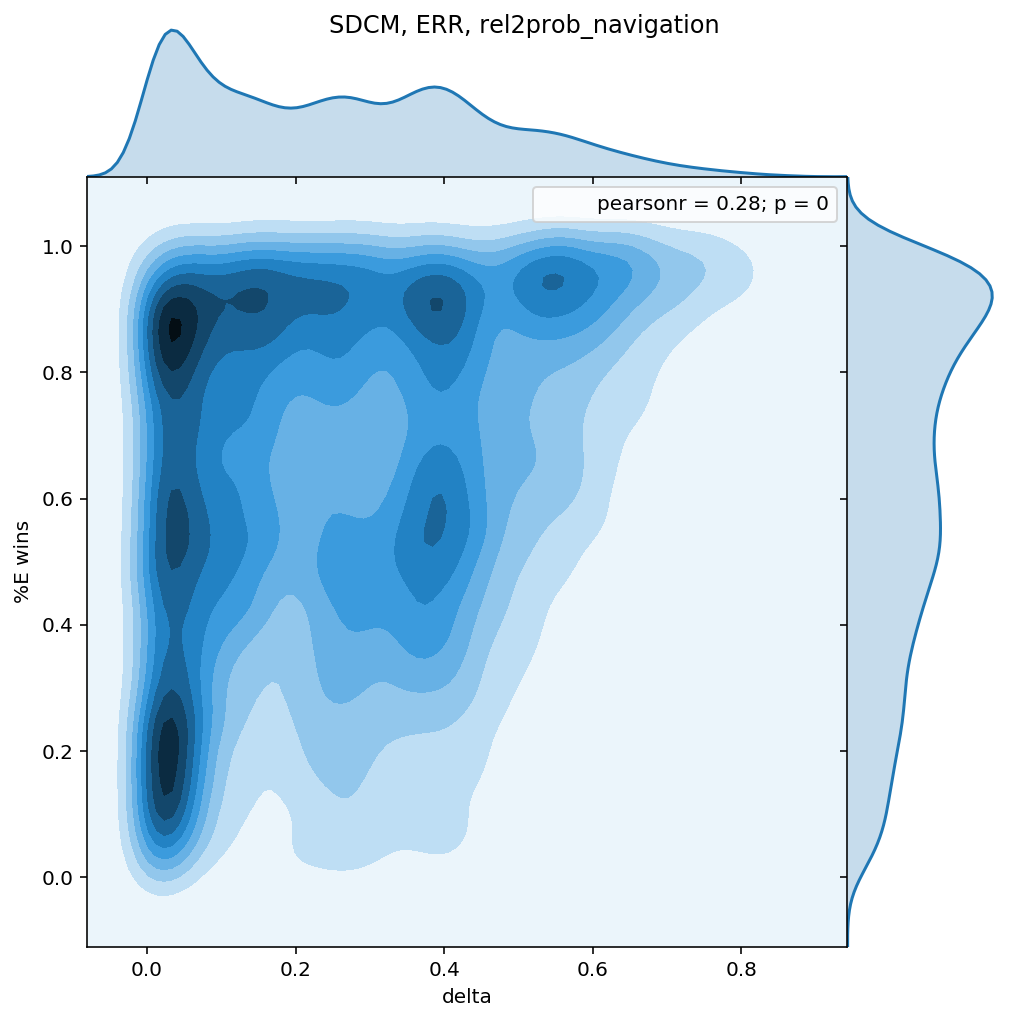

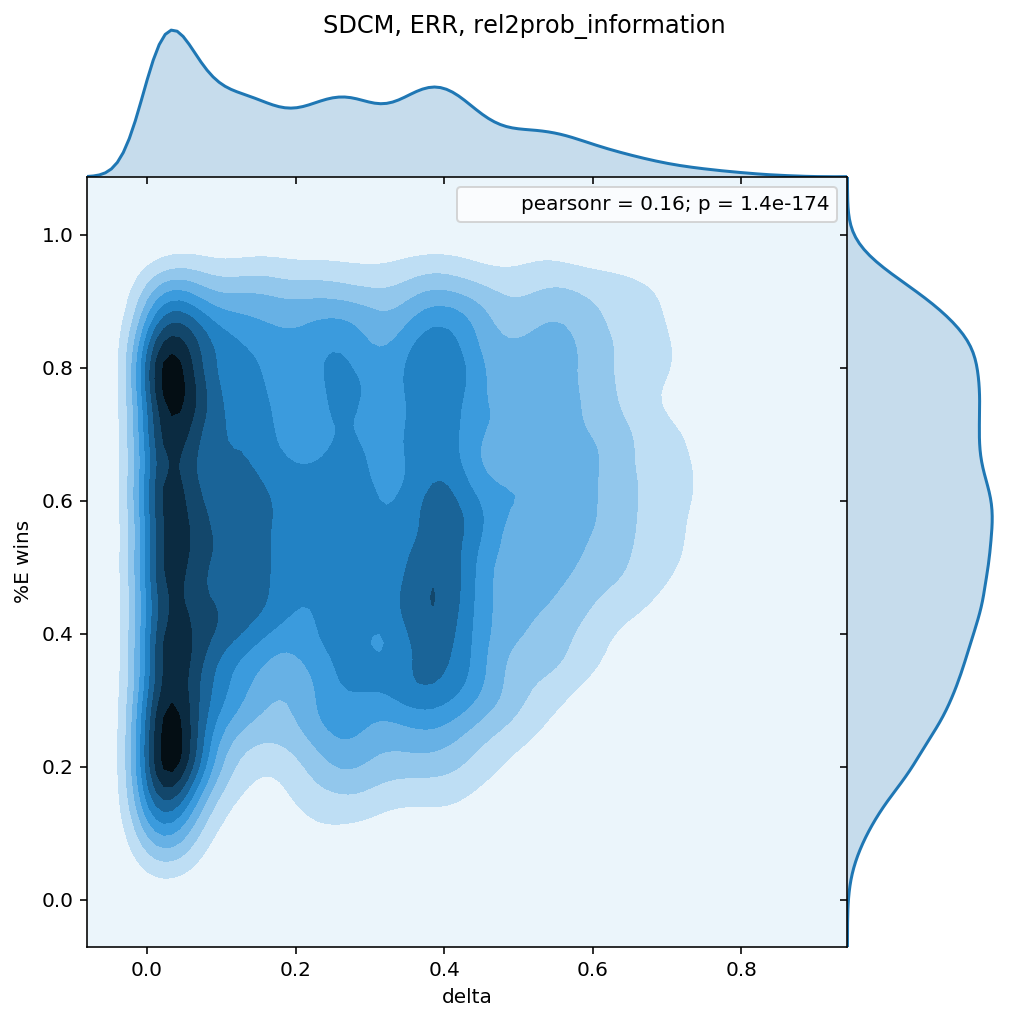

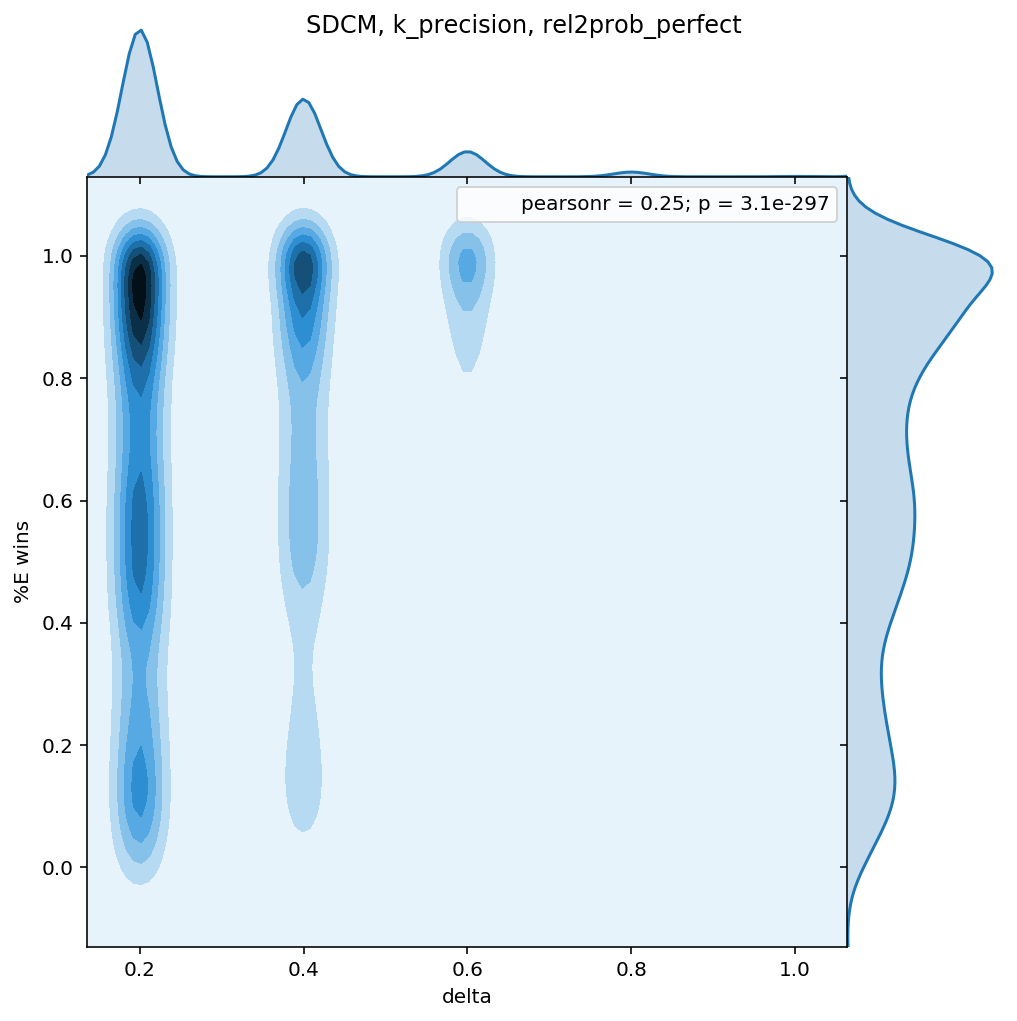

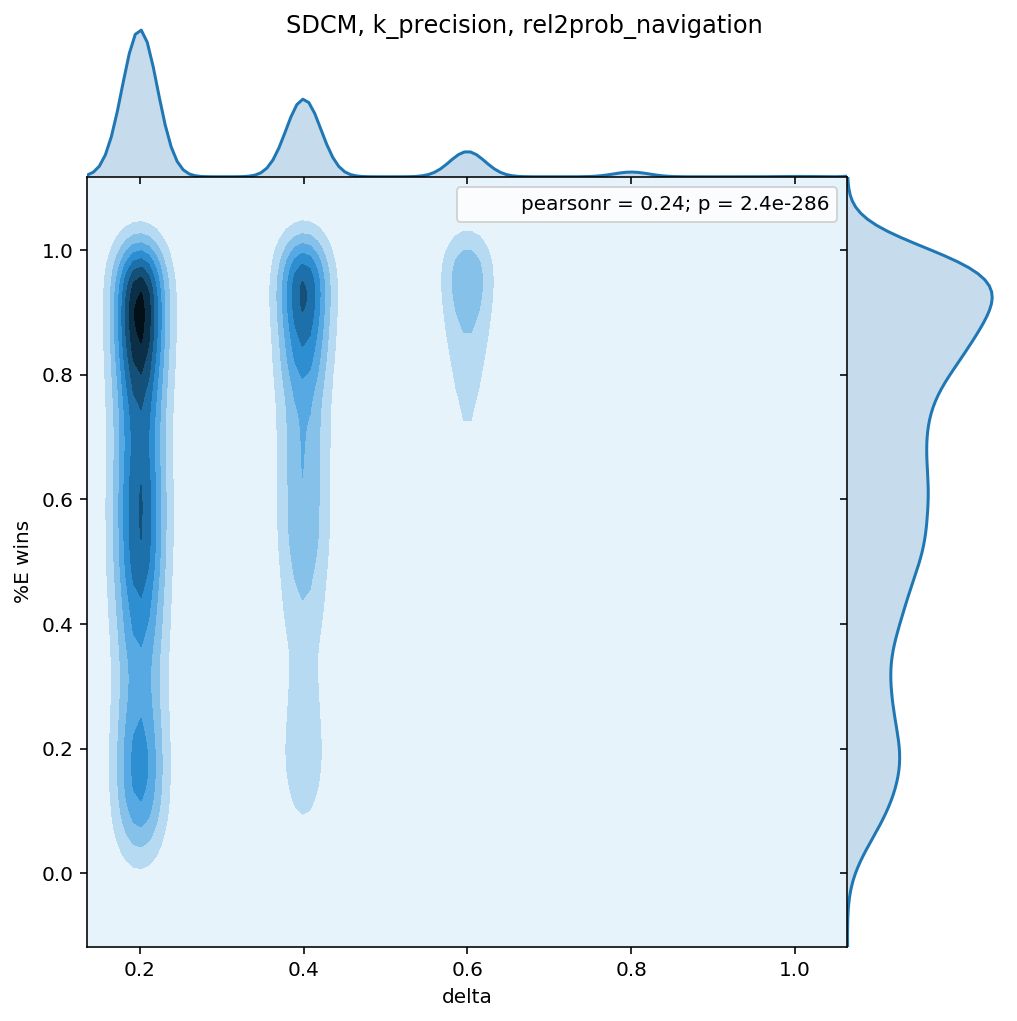

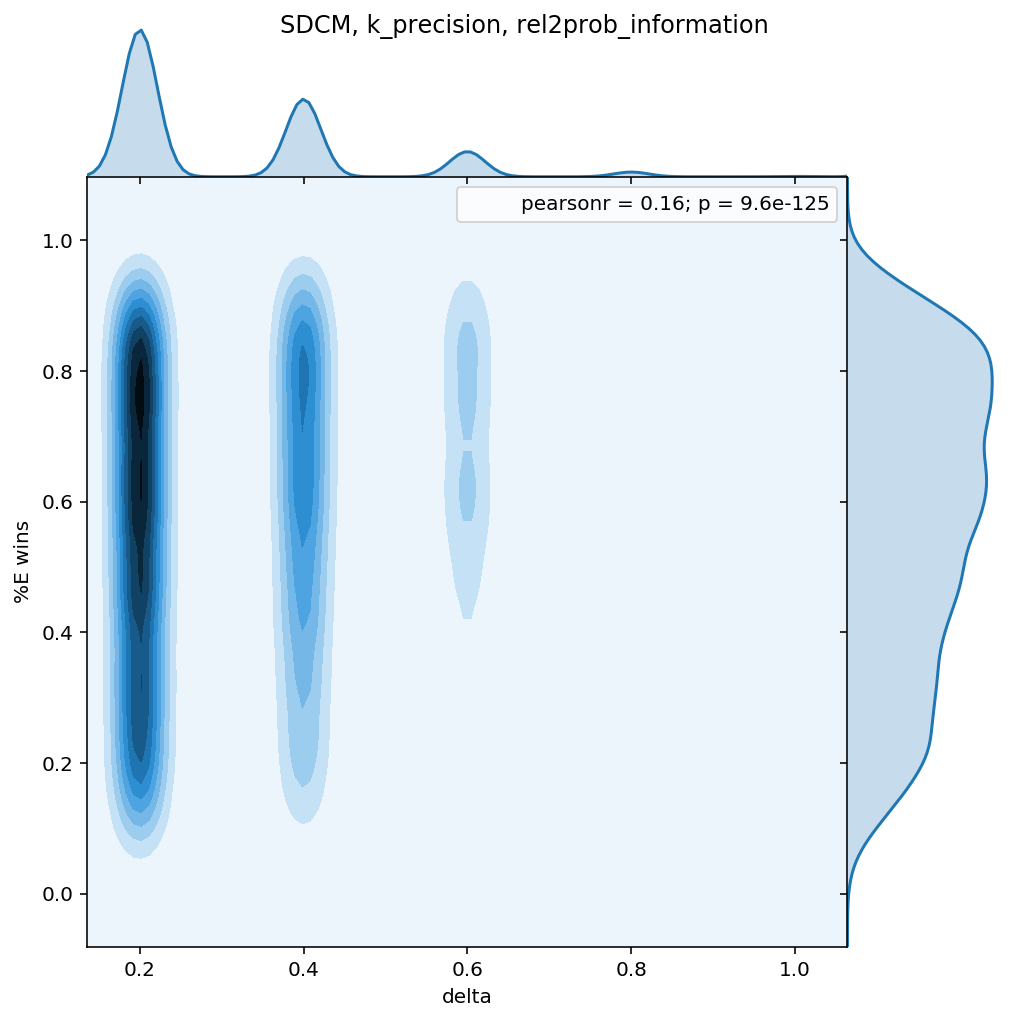

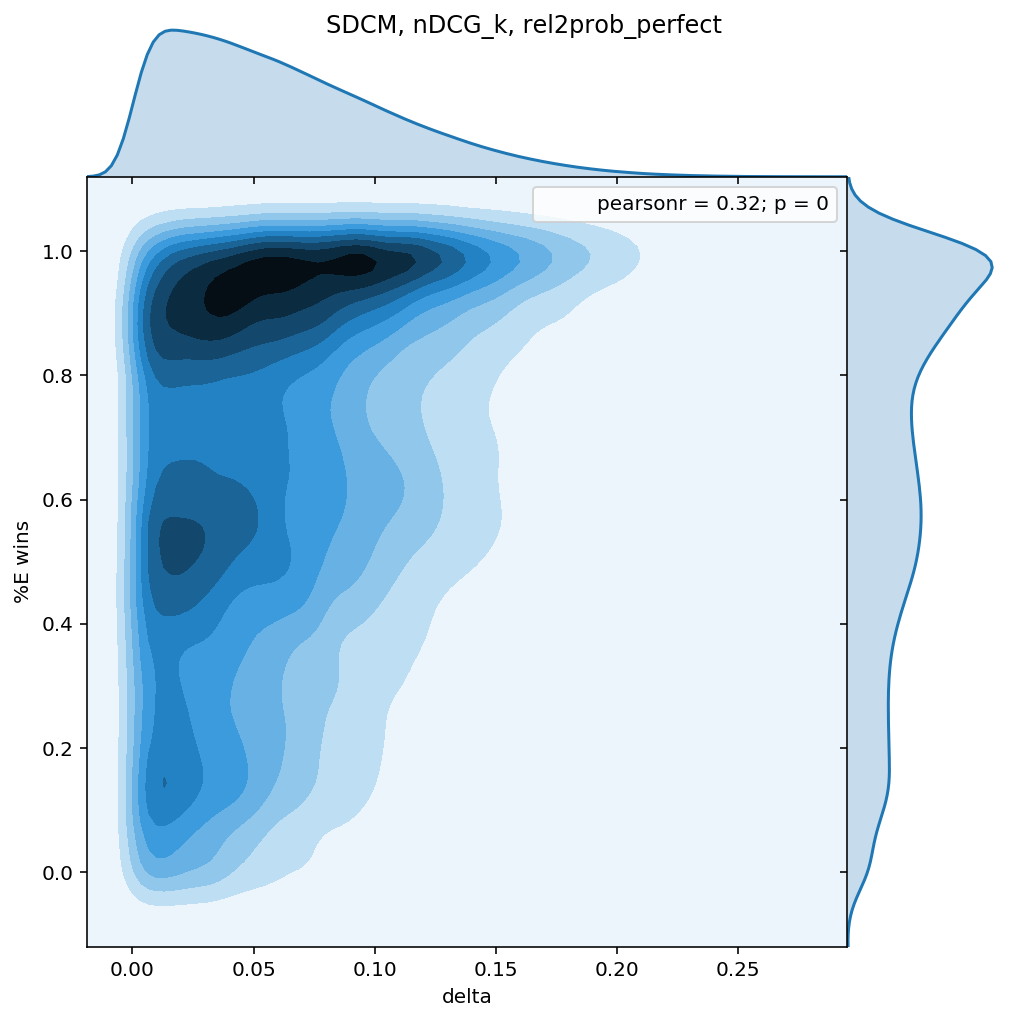

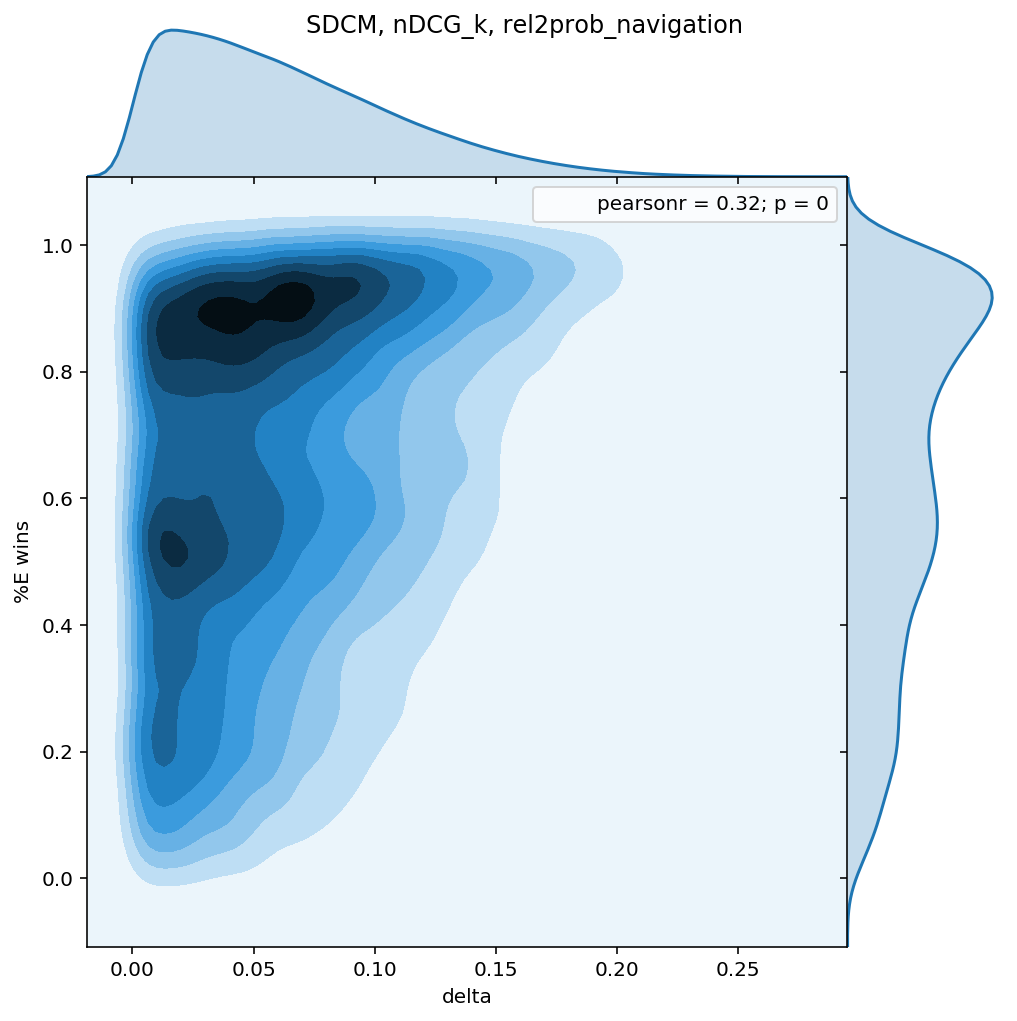

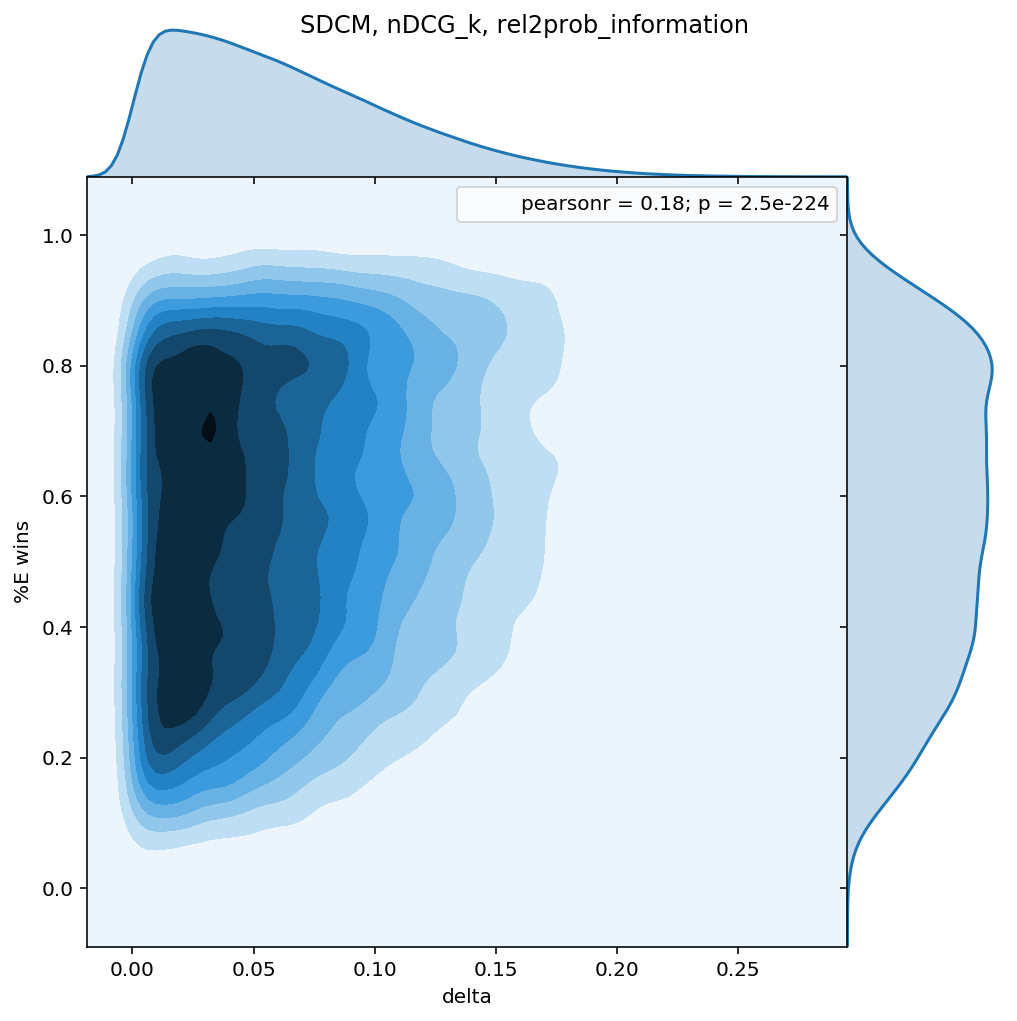

In [17]:
def SDCM_plot(k, N):
    for i, eval_model in enumerate([ERR, k_precision, nDCG_k]):
        for j, rel2prob in enumerate([rel2prob_perfect, rel2prob_navigation, rel2prob_information, ]):
            model = SDCM('YandexRelPredChallenge.txt', rel2prob)
            delta, props = full_sim(eval_model, model, p_ranking, e_ranking, k, N, True)
            ax = sns.jointplot(np.array(delta), np.array(props), kind="kde", size=7, space=0).set_axis_labels("delta", "%E wins")
            ax.fig.suptitle('SDCM, {0}, {1}'.format(eval_model.__name__, rel2prob.__name__))
            plt.show()
SDCM_plot(5, 30)

Analyzing the plots with different actractiveness parameters, we find that there is no qualitative difference between the results that use the perfect model and those that use the navigational model. This is reasonable since the probabilities are very similar. The resuls are different when using the informational model, for which we consistenly observe a reduction in the correlation coefficient (on top right of every plot) and we see that the plots are qualitatively more spreaded.

Another interesting comparison is between the offline measures. Plotting the distributions of $p$, the number of wins for algorithm E, in the case of E being the winning algorithm, we see that ERR has a much heavier tail than nDCGk. In fact, nDCGk does even have almost no occurence with value greater than 0.2, while the most rare events for ERR are those with value greater than 0.8. K precision behaves in a different way instead, since it can assume only a very small range of values given our scoring for documents and that we are using rankings of length 5.

To have an idea of the distribution of the pairs of delta and p values, we use the joint plot above. We can see that there is a small positive correlation between those values as delta becomes higher. While for small deltas the interleaving can produce any value of winning probability p, the more we increase the delta value, the less low values for p are present. This indicates some kind of correlation, although it is still not very strong. However, these correlations have been proved to be significant, which you can see from the Pearson R value, displayed in the corner of the joint plot. Surprisingly, the variance of $p$ for small values of delta is very large, and this holds for every plot.
Notice that because of this we cannot say there is a strong proportionality between offline and online measures. In fact, the value of delta measure does not always give information about the possible values for $p$, since this holds only for large values of delta.
 

##### Conclusion

We run experiments where we compared different online and offline evaluation metrics in order to understand the relationship between them. We see that on those instanses where the experimental (E) algorithm outperformed the production algorithm (P), the online metric also showed significant difference in favor of the E algorithm based on the Sign test. While the Random Click Model does not takes document ranks into consideration and could not provide any significant correlations with the offline measures, the Dependent Click Model showed that there is a slight positive correlation between the online and offline metrics. We conclude that the two measures point in the same direction, but one could not be replaced with the other.